In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
columns = [
    'Weight on Bit (klbs)',
    'Rotary RPM (RPM)',
    'Total Pump Output (gal_per_min)',
    'Rate Of Penetration (ft_per_hr)',
    'Standpipe Pressure (psi)',
    'Rotary Torque (kft_lb)', 
    'Hole Depth (feet)', 
    'Bit Depth (feet)'
]

In [3]:
datasets = [
    "78B-32 1 sec data 27200701.csv",
    "56-32 1sec data 27029986.csv"
]

In [4]:
df = pd.read_csv(f"MaskedAutoencoder\\{datasets[0]}")
df = df[columns]
df

,Weight on Bit (klbs),Rotary RPM (RPM),Total Pump Output (gal_per_min),Rate Of Penetration (ft_per_hr),Standpipe Pressure (psi),Rotary Torque (kft_lb),Hole Depth (feet),Bit Depth (feet)
0,0.0,0.03,0.0,0.0,0.0,0.00,55.9,16.5
1,0.0,0.00,0.0,0.0,0.0,0.00,55.9,16.5
2,0.0,0.00,0.0,0.0,0.0,0.00,55.9,16.5
3,0.0,0.03,0.0,0.0,0.0,0.00,55.9,16.5
4,0.0,0.00,0.0,0.0,0.0,0.00,55.9,16.5
...,...,...,...,...,...,...,...,...
2928972,0.0,-999.25,0.0,0.0,0.0,-999.25,9500.0,654.3
2928973,0.0,-999.25,0.0,0.0,0.0,-999.25,9500.0,654.3
2928974,0.0,-999.25,0.0,0.0,0.0,-999.25,9500.0,654.3
2928975,0.0,-999.25,0.0,0.0,0.0,-999.25,9500.0,654.3


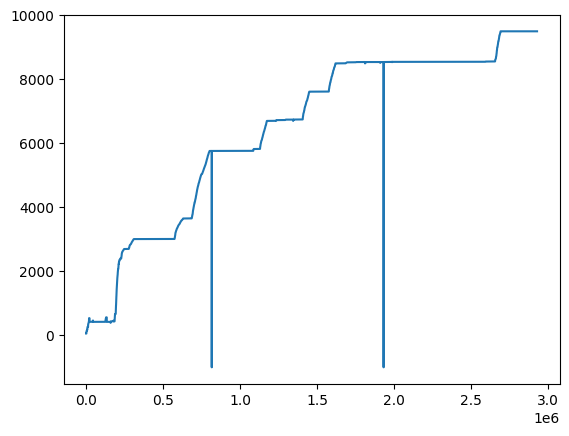

In [5]:
plt.plot(df["Hole Depth (feet)"])

In [36]:
pd.concat(drilling_segments).max()

Weight on Bit (klbs)                241.000
Rotary RPM (RPM)                    113.820
Total Pump Output (gal_per_min)    1501.300
Rate Of Penetration (ft_per_hr)     366.540
Standpipe Pressure (psi)           4102.220
Rotary Torque (kft_lb)               53.833
Hole Depth (feet)                  9500.000
Bit Depth (feet)                   9500.000
dtype: float64

In [37]:
## Drilling only
##Split into drilling segments

base_mask = (
    (df["Hole Depth (feet)"].rolling(10000).mean().diff() > 0) &
    (df["Hole Depth (feet)"] == df["Bit Depth (feet)"]) &
    (df["Hole Depth (feet)"] > 1000)
)

window = 100       # Rolling window size
threshold = 0.3    # Keep if rolling average > threshold

# Compute rolling average of the mask (convert to 0/1 first)
rolling_avg = base_mask.astype(float).rolling(window).mean()

# Final mask based on rolling average threshold
final_mask = (rolling_avg > threshold).fillna(0)

final_mask = final_mask.astype(float).rolling(20000).mean() > 0.6

masked_hole_depth = df["Hole Depth (feet)"].where(final_mask, np.nan)

gap_threshold = 100  # maximum number of consecutive NaNs to merge segments

# Identify indices of non-NaN values
not_nan_idx = masked_hole_depth[masked_hole_depth.notna()].index

# Grouping non-NaN indices based on closeness
groups = []
current_group = []

for i, idx in enumerate(not_nan_idx):
    if i == 0:
        current_group.append(idx)
        continue

    # Check gap from previous index
    if idx - not_nan_idx[i-1] <= gap_threshold:
        current_group.append(idx)
    else:
        groups.append(current_group)
        current_group = [idx]

# Append last group
if current_group:
    groups.append(current_group)

# Fix all NaNs
drilling_segments = [  ]
window_size = 100
for group in groups:
    dfg = df.loc[group].copy()
    
    for col in dfg.columns:
        if np.issubdtype(dfg[col].dtype, np.number):
            series = dfg[col]      
            rolling_mean = series.rolling(window=window_size, min_periods=1, center=True).mean()
            dfg[col] = series.fillna(rolling_mean).bfill(  ).ffill()

    drilling_segments.append(dfg)

# Min Max Normalization
global_min = pd.concat(drilling_segments).min()
global_max = pd.concat(drilling_segments).max()

# Step 2: Normalize each dataframe
normalized_drilling_segments = []
for df in drilling_segments:
    normalized_df = (df - global_min) / (global_max - global_min)
    normalized_drilling_segments.append(normalized_df)

len(normalized_drilling_segments)

9

In [ ]:
# Segment into windows